# Probabilistic Programming 2: Mixture modeling
## Variational inference

In this notebook, we are exploring a more complex problem set using variational inference, namely mixture modeling. It will show you how to deal with the multivariate case.

### Preliminaries

- Goal 
  - Write a variational inference procedure for a 2-dimensional mixture model.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Getting started with ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).
    - [Demos in ForneyLab](https://github.com/biaslab/ForneyLab.jl/tree/v0.10.0/demo)
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

In [15]:
# Package managing
using Pkg;Pkg.activate("workspace");Pkg.instantiate();

using Logging; disable_logging(LogLevel(0))
using Distributions: MvNormal
using StatsPlots
using LaTeXStrings
using ForneyLab

Activating environment at `~/Documents/biaslab/repos/BMLIP/lessons/notebooks/probprog/workspace/Project.toml`


## Data generation

We generate samples from three 2-dimensional Gaussian distributions and mix these. These Gaussians are:

$$
\begin{align*}
\mathcal{N}_1(\begin{bmatrix}-2, -2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 3 \end{bmatrix}) \, , \quad
\mathcal{N}_2(\begin{bmatrix}+2, +2 \end{bmatrix}, \begin{bmatrix}3 & 0 \\0 & 1 \end{bmatrix}) \, , \quad
\mathcal{N}_3(\begin{bmatrix}-2, +2 \end{bmatrix}, \begin{bmatrix}1 & 0 \\0 & 1 \end{bmatrix}) \, .
\end{align*}
$$

We draw $N_1$, $N_2$ and $N_3$ samples from each, respectively.

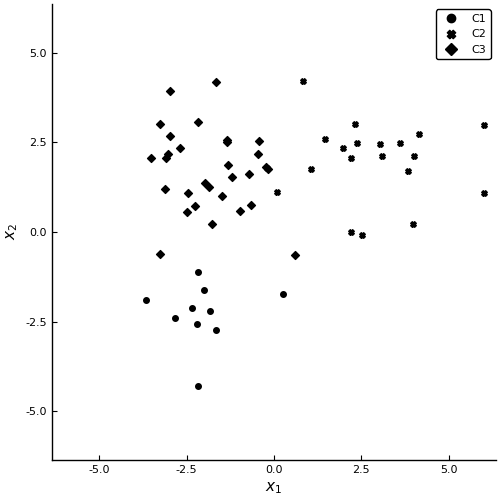

In [16]:
# Sample size
N1 = 10
N2 = 20
N3 = 30

# Parameters for each cluster
μ1 = [-2. -2.]
Σ1 = [1.0 0.0; 0.0 3.0]
μ2 = [+2. +2.]
Σ2 = [3.0 0.0; 0.0 1.0]
μ3 = [-2. +2.]
Σ3 = [1.0 0.0; 0.0 1.0]

function generate_data(means::Array{Float64,2}, covariances::Array{Float64,3}; num_samples::Array{Int64,1}=[10])
    "Generate data from a 2-dimensional mixture model"
    
    # Extract number of components
    K = length(num_samples)
    
    # Extract dimensionality
    D = size(covariances)[1]
    
    # Preallocate vectors
    X = zeros(sum(num_samples), D)
    C = zeros(sum(num_samples),)
    
    # Create sample index
    ix = cat(0, cumsum(num_samples), dims=1)
    
    for k = 1:K
        
        # Current indices
        ix_k = (ix[k]+1:ix[k+1])
    
        # Sample from cluster component
        X[ix_k, :] = rand(MvNormal(means[k,:], covariances[:,:,k]), num_samples[k])'
        
        # Store cluster origin
        C[ix_k,] = k*ones(num_samples[k])
        
    end
    
    return X, C
end

# Generate data
observations, cluster = generate_data(cat(μ1, μ2, μ3, dims=1), cat(Σ1, Σ2, Σ3, dims=3), num_samples=[N1, N2, N3])

# Total sample size
N = sum([N1, N2, N3])

# Visualization
scatter(observations[cluster .== 1, 1], observations[cluster .== 1, 2], marker=:circle, color="black", label="C1")
scatter!(observations[cluster .== 2, 1], observations[cluster .== 2, 2], marker=:xcross, color="black", label="C2")
scatter!(observations[cluster .== 3, 1], observations[cluster .== 3, 2], 
         marker=:diamond,
         color="black", 
         label="C3", 
         xlabel=L"$x_1$", 
         ylabel=L"$x_2$", 
         xlim=[-6, 6], 
         ylim=[-6, 6], 
         size=(500,500),
         grid=false)

## Model specification

Let's quickly recap the $K$-component Gaussian mixture model. 

We have a data set of $X$ of $N$ samples by $D$ features. Each component is a Gaussian distribution, $ p_k(x \mid \mu_k, \Sigma_k) \triangleq \mathcal{N}(x \mid \mu_k, \Sigma_k)$. In total, we model $N$ samples:

$$ p(X \mid z, \mu, \Sigma) = \sum_{i=1}^{N} \sum_{k=1}^{K} p_k(x_i \mid \mu_k, \Sigma_k)^{z_i=k} \, .$$

<!-- Note that we summarize parameters as follows: $\phi = (\phi_1, \dots, \phi_K), \mu = (\mu_1, \dots, \mu_K), \Sigma = (\Sigma_1, \dots, \Sigma_K)$.  -->
The variable $z_i$ is the assignment of sample $i$ to class $k$. The probability $p(z_{i} = k)$ is also called the _responsibility_ of component $k$ for the $i$-th sample. All $z_i$ follow a Categorical distribution with mixture weights as parameters:

$$ p(z_i) \sim \text{Cat}(\phi) \, ,$$

Being Bayesians, we put priors on all unknown parameters ($\phi, \mu, \Sigma$):

$$ \begin{align}
p(\phi) \sim&\ \text{Dir}(a_0) \\
p(\mu) \sim&\ \mathcal{N}(m_0, l_0^{-1}\Sigma) \\
p(\Sigma) \sim&\ \mathcal{W}(W_0, v_0) \end{align} \, .$$

The distribution for the mixture weights, $p(\phi)$, follows a Dirichlet distribution because it is a vector that should sum to one. The component parameter priors are a Wishart distribution for the covariance matrix and a Gaussian distribution for the mean, conditioned on the sampled covariance matrix. Together, these two priors form a [Normal-Inverse-Wishart distribution](https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution), $p(\mu, \Sigma)$, which is the conjugate prior for the Gaussian components. The full joint distribution is therefore:

$$ \begin{align} p(X, z, \phi, \mu, \Sigma) =&\ p(X \mid z, \phi, \mu, \Sigma)\ p(z \mid \phi)\ p(\mu, \Sigma)\ p(\phi) \\
=&\ \sum_{i=1}^{N} \sum_{k=1}^{K} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)^{z_i=k}\ \text{Cat}(z_i=k \mid \phi_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k})\ \text{Dir}(\phi_k \mid a_{0k}) \end{align}$$

We are interested in the posterior distribution over $z$, which assigns the current samples to clusters via $\arg \max_{k} p(z_i = k)$. For example, if the posterior distribution for $z_i$ is $[0.32\ 0.21\ 0.47]$, then the $\arg \max_k$ is 3 and we say that $x_i$ belongs to component 3. We are also interested in the posterior distributions for the component parameters, because these allow us to assign future samples to the current clusters. The posterior for $z, \phi, \mu, \Sigma$ has the form:

$$p(z, \phi, \mu, \Sigma \mid X) = \frac{p(X, z, \phi, \mu, \Sigma)}{\int p(X, z, \phi, \mu, \Sigma)\ \mathrm{d}X} \, .$$

We cannot evaluate the integral in the denominator, but because it only serves as a normalization factor we ignore it for now. Note that the numerator is the joint distribution. Unfortunately, it doesn't simplify to a known form. However, in mixture models, it is usually possible to perform a conditional factorization into the two distributions: if we fix the parameters $\phi, \mu, \Sigma$ to certain values, we obtain the factor:

$$p(z_i \mid X, \phi, \mu, \Sigma) = \sum_{i=1}^{N} \sum_{k=1}^{K} \rho_k^{z_i = k} \, ,$$

where $\rho_k = \phi_k \mathcal{N}(x_i \mid \mu_k, \Sigma_k)$ for all $k$. This is a Categorical distribution! The only problem is that $\rho$ is not normalized correctly. But we know that it _should_ be correctly normalized, after division by the denominator $\int p(X, z, \phi, \mu, \Sigma) \ \mathrm{d}X$. We can therefore perform the following re-parameterization:

$$r_k = \frac{\rho_k}{\sum_{k} \rho_k} \, .$$

Now, $r_k$ are valid responsibilities for the assignment variable $z$. In other words, $p(z_i \mid X, \phi, \mu, \Sigma) \sim \text{Cat}(r_k)$. 

If we fix $z_i$ to certain values, it acts as a component selector. Take for instance $z_i = 2$;

$$\begin{align} p(\phi_2, \mu_2, \Sigma_2 \mid x_i, z_i) =&\quad \mathcal{N}(x_i \mid \mu_1, \Sigma_1)^{0} \ 0\ \ \ \mathcal{NIW}(\mu_1, \Sigma_1 \mid m_{01}, l_{01}, W_{01}, v_{01}) \ \text{Dir}(\phi_1 \mid a_{01}) \\
&+ \mathcal{N}(x_i \mid \mu_2, \Sigma_2)^{1} \ \phi_2\ \mathcal{NIW}(\mu_2, \Sigma_2 \mid m_{02}, l_{02}, W_{02}, v_{02}) \ \text{Dir}(\phi_2 \mid a_{02}) \\
&+ \mathcal{N}(x_i \mid \mu_3, \Sigma_3)^{0} \ 0\ \ \ \mathcal{NIW}(\mu_3, \Sigma_3 \mid m_{03}, l_{03}, W_{03}, v_{03}) \ \text{Dir}(\phi_3 \mid a_{03}) \\
=& \ \mathcal{N}(x_i \mid \mu_2, \Sigma_2) \ \phi_2\ \mathcal{NIW}(\mu_2, \Sigma_2 \mid m_{02}, l_{02}, W_{02}, v_{02}) \ \text{Dir}(\phi_2 \mid a_{02})  \end{align} \, .$$

Fixing all $z_i$ produces $p(\phi, \mu, \Sigma \mid X, z)$. This can be further factorized into $p(\phi \mid z) p(\mu, \Sigma \mid X)$:

$$\begin{align} 
p(\phi_k \mid z) =&\ \sum_{i=1}^{N} \text{Cat}(z_i \mid \phi_k)\ \text{Dir}(\phi_k \mid a_{0}) \\ 
p(\mu_k, \Sigma_k \mid X) =&\ \sum_{i=1}^{N} \mathcal{N}(x_i \mid \mu_k, \Sigma_k)\ \mathcal{NIW}(\mu_k, \Sigma_k \mid m_{0k}, l_{0k}, W_{0k}, v_{0k}) 
\end{align}$$

which are Dirichlet and a Normal-Inverse-Wishart distributions. So, to summarize:

1. Fix $\phi, \mu, \Sigma$ and compute $p(z \mid X, \phi, \mu, \Sigma)$
2. Fix $z$ and compute both $p(\phi \mid z)$ and $p(\mu, \Sigma \mid X)$.

You will recognize this as being similar to Expectation-Maximization. The difference lies in that we obtain posterior distributions for $\phi, \mu, \Sigma$ instead of point estimates. 

Since the posterior factorizes into marginal distributions into known forms (i.e. Categorical, Dirichlet, Normal, Wishart), we can approximate it using an appropriate recognition distribution.

In [17]:
# Start a graph
g = FactorGraph()

# Mixture weights are drawn from a Beta distribution (1D analog of a Dirichlet)
@RV phi ~ Beta(1.0, 1.0)

# Marginals for first component
@RV W_1 ~ Wishart([1. 0.; 0. 1.], 2.)
@RV m_1 ~ GaussianMeanPrecision([0.0, 0.0], W_1)

# Marginals of second component
@RV W_2 ~ Wishart([1. 0.; 0. 1.], 2.)
@RV m_2 ~ GaussianMeanPrecision([0.0, 0.0], W_2)

z = Vector{Variable}(undef, N)
y = Vector{Variable}(undef, N)
for i = 1:N
    
    # Assignment variable is drawn from a Bernoulli distribution (1D analog of a Categorical)
    @RV z[i] ~ Bernoulli(phi)
    
    # ForneyLab has a special node for a Gaussian mixture component
    @RV y[i] ~ GaussianMixture(z[i], m_1, W_1, m_2, W_2)
    
    # Add data 
    placeholder(y[i], :y, dims=(2,), index=i)
end

Now, you need to specify a distribution with which you will approximate the posterior distribution that you would normally obtain through exact Bayesian inference.

In [18]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(phi, m_1, W_1, m_2, W_2, z, ids=[:PHI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

Now, we execute the inference algorithm.

In [19]:
# Convert data to a format suited to ForneyLab
observed_ = [observations[i,:] for i in 1:N]

# Add to data dictionary
data = Dict(:y => observed_)

# Prepare recognition distributions
marginals = Dict(:phi => ProbabilityDistribution(Beta, a=1.0, b=1.0),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[-1.0, +1.0], w=[1. 0.;0. 1.]),
                 :W_1 => ProbabilityDistribution(MatrixVariate, Wishart, v=[1. 0.;0. 1.], nu=2.),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=[+1.0, -1.0], w=[1. 0.;0. 1.]),
                 :W_2 => ProbabilityDistribution(MatrixVariate, Wishart, v=[1. 0.;0. 1.], nu=2.))
for i = 1:N
    marginals[:z_*i] = ProbabilityDistribution(Bernoulli, p=1/2.)
end

# Execute algorithm
num_iterations = 20

# Preallocate free energy tracking array
F = Float64[]

for i = 1:num_iterations
    
    stepZ!(data, marginals)
    stepPHI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end


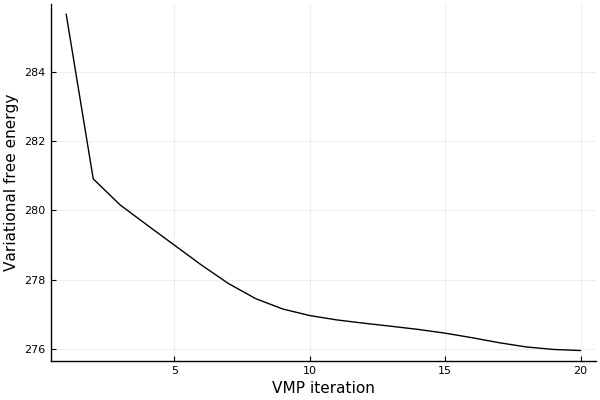

In [20]:
# Plot free energy to check for convergence
plot(1:num_iterations, F, color="black", label="")
xlabel!("VMP iteration")
ylabel!("Variational free energy")

Visualize the results.

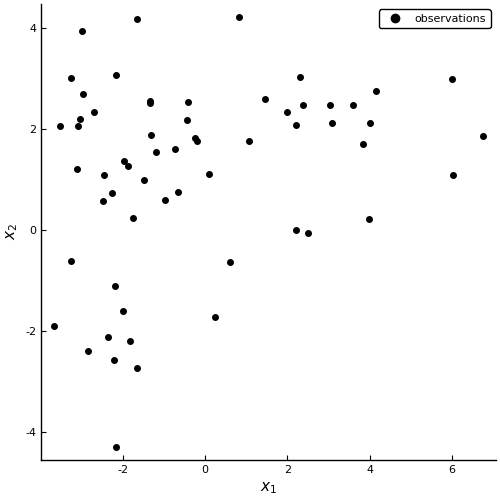

In [21]:
include("../scripts/pp-2.jl")

# Estimated means. Using ForneyLab.unsafeMean allows for retrieving the estimates in cases where positive definiteness is violated by numerical errors
μ1_estimated = ForneyLab.unsafeMean(marginals[:m_1])
μ2_estimated = ForneyLab.unsafeMean(marginals[:m_2])
Σ1_estimated = ForneyLab.unsafeMean(marginals[:W_1])
Σ2_estimated = ForneyLab.unsafeMean(marginals[:W_2])

# Plot data and overlay estimated posterior probabilities
plot_posteriors(observations, μ1_estimated, μ2_estimated, Σ1=Σ1_estimated, Σ2=Σ2_estimated, x1=range(-10,stop=10), x2=range(-10,stop=10))